In [401]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_finance as yf
import pandas_datareader as pdr
from datetime import date
from sklearn.cluster import KMeans
from statsmodels.tsa.api import adfuller
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from statsmodels.regression.rolling import RollingOLS

# Modify some settings
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

import plotly.express as px
import plotly.graph_objects as go

In [402]:


class ChartBuilder(object):
    
    def __init__(self, s1, s2, start, end, exit=0, long_stop = -3, short_stop = 3, long_enter = -2, short_enter = 2):
        
        self.s1 = s1
        self.s2 = s2
        self.start = start
        self.end = end
        self.exit = exit
        self.long_stop = long_stop
        self.short_stop = short_stop
        self.long_enter = long_enter
        self.short_enter = short_enter
        
        self.pair = str("{} and {} ".format(self.s1, self.s2))
        self.scale = str(" ({} - {})".format(self.start, self.end))
        
# Customized Area chart

    def plot(self, signal_data, metric_data, metric, add_signal_levels = True, add_trades = True):
        
        
        self.signal_data = signal_data
        self.metric_data = metric_data
        self.data = pd.concat([self.signal_data, self.metric_data], axis = 1)
        self.metric = str(metric) 
        self.add_signal_levels = add_signal_levels
        self.add_trades = add_trades
        self.title = self.pair + self.metric + self.scale
        self.y0 = self.data[self.metric].max()
        self.y1 = self.data[self.metric].min()
        c_line = px.line(x = self.data.index, y = self.data[self.metric], title = self.title)

        c_line.update_xaxes(
            title_text = 'Date',
            rangeslider_visible = True,
            rangeselector = dict(
                buttons = list([
                    dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                    dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                    dict(count = 1, label = 'YTD', step = 'year', stepmode = 'todate'),
                    dict(count = 1, label = '1Y', step = 'year', stepmode = 'backward'),
                    dict(step = 'all')])))
        
        if self.add_signal_levels == True:
            if self.metric == 'Z_Score':
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.exit, y1 = self.exit, line=dict(color = 'orange', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.short_stop, y1 = self.short_stop, line=dict(color = 'red', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.long_stop, y1 = self.long_stop, line=dict(color = 'red', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.long_enter, y1 = self.long_enter, line=dict(color = 'green', width = 2, dash = 'dash'))
                c_line.add_shape(type = "line", x0 = self.start, x1 = self.end, y0 = self.short_enter, y1 = self.short_enter, line=dict(color = 'green', width = 2, dash = 'dash'))
        
        if self.add_trades == True:
            enter = self.data['Short_Signal'].gt(0.5)
            exit = self.data['Cover_Short'].gt(0.5)
            shorts = pd.concat([enter, exit], axis=1)
            shorts = shorts[~((~shorts).all(axis=1))]
            shorts.reset_index(level=0, inplace=True)
            ff = []
            ll = []
            f = shorts.loc[shorts['Short_Signal'] == True, 'Date']
            l = shorts.loc[shorts['Cover_Short'] == True, 'Date']
            run_f = True
            run_l = True
            if shorts.iloc[0]['Short_Signal'] == False:
                ff.append(self.start)
                for i in f:
                    ff.append(i)
                run_f = False
            elif shorts.iloc[-1]['Short_Signal'] == True:
                for i in l:
                    ll.append(i)
                ll.append(self.end)
                run_l = False
            
            if run_f == True:
                for i in f:
                    ff.append(i)
            if run_l == True:
                for i in l:
                    ll.append(i)
                    
            ts = pd.DataFrame(columns = ['first', 'last'])
            ts['first'] = ff
            ts['last'] = ll

            for index, row in ts.iterrows():
                c_line.add_shape(type = 'rect', 
                              x0 = row['first'], 
                              y0 = self.y0, 
                              x1 = row['last'], 
                              y1 = self.y1, 
                              line=dict(color="rgba(0,0,0,0)", width=3,), fillcolor='red', opacity = 0.2, layer='below')
            
            enter = self.data['Long_Signal'].gt(0.5)
            exit = self.data['Close_Long'].gt(0.5)
            longs = pd.concat([enter, exit], axis=1)
            longs = longs[~((~longs).all(axis=1))]
            longs.reset_index(level=0, inplace=True)
            ff = []
            ll = []
            f = longs.loc[longs['Long_Signal'] == True, 'Date']
            l = longs.loc[longs['Close_Long'] == True, 'Date']
            run_f = True
            run_l = True
            if longs.iloc[0]['Long_Signal'] == False:
                ff.append(self.start)
                for i in f:
                    ff.append(i)
                run_f = False
            elif longs.iloc[-1]['Long_Signal'] == True:
                for i in l:
                    ll.append(i)
                ll.append(self.end)
                run_l = False
            
            if run_f == True:
                for i in f:
                    ff.append(i)
            if run_l == True:
                for i in l:
                    ll.append(i)
                    
            ts = pd.DataFrame(columns = ['first', 'last'])
            ts['first'] = ff
            ts['last'] = ll

            for index, row in ts.iterrows():
                c_line.add_shape(type = 'rect', 
                              x0 = row['first'], 
                              y0 = self.y0, 
                              x1 = row['last'], 
                              y1 = self.y1, 
                              line=dict(color="rgba(0,0,0,0)", width=3,), fillcolor='green', opacity = 0.2, layer='below')

        c_line.update_yaxes(title_text = self.metric)
        c_line.update_layout(showlegend = False,
            title = {
                'text': self.title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})

        c_line.show()

In [403]:
class statarb(object):
    '''
    Attributes
    ----------
        s1: str
            name of stock 1
        s2: str
            name of stock 2
        start: datetime
            start date of backtest period
        end: datetime
            end date of backtest period
        ma: int
            moving average window used in calc of rolling z-score (default = 28)
        floor / ceiling: float
            trade entry criteria (default = +/-2.0)
        stop_loss_long / short: float
            trade stop loss criteria (default = +/-3.0)
        beta_lookback: int
            lookback window used when calculating hedge ratio (default = 14)
        allocation: int
            dollar value of funds to use (default = 10,000)
        exit_zscore: float
            Z-score at which we close position (default = 0) 
        show_plot: boolean
            define if you want to see charts
    ----------
    
    Methods
    -------
        show_pair()
            displays daily price charts of chosen stocks through chosen dates
        test_coint()
            returns if pair is cointergrated to quickly check if its worth back testing
        backtest_pair()
            backtests pair using all methods below
        generate_spread()
            takes daily closing prices, caluclating the hedge ratios and spreads of the assets
        generate_cointergration()
            Checks if the pair is currently cointergrated and to what significance
        generate_signal()
            takes spread and generates signals indicating trade entry / exit / stop out for long and short positions
        generate_trades()
            defines the postions of both stocks in the pair. i.e. long trade, stock 1 = positive, stock 2 = negative
        generate_portfolio()
            shows our portfolio returns and equity curve
        generate_order_book()
            shows the dates on which we would of placed orders (buy or sell) for each stock and quantity of shares for each
        generate_metrics()
            Shows various portfolio and return metrics e.g. sharp ratio, avg wins / lossesetc
    -------
    '''
    def __init__(self, s1, s2, start, end, ma=28, floor=-2.0, ceiling=2.0, stop_loss_long=-3.0, stop_loss_short=3.0, beta_lookback=28, allocation=10000, exit_zscore=0, show_plot = True):
        self.s1 = s1 # name of stock one
        self.s2 = s2 # name of stock two 
        self.df1 = pdr.get_data_yahoo(s1, start, end) # dataframe of stock one
        self.df2 = pdr.get_data_yahoo(s2, start, end) # dataframe of stock two
        self.df = pd.DataFrame(index = self.df1.index) # new df for data_cleaning method
        self.signals = pd.DataFrame(index = self.df1.index)
        self.trades = pd.DataFrame(index = self.df1.index)
        self.portfolio = pd.DataFrame(index = self.df1.index)
        self.metrics = pd.DataFrame(index = self.df1.index)
        self.book = pd.DataFrame(index = range(len(self.df1)))
        self.ma = ma # moving average period
        self.floor = floor # buy threshold for z-score
        self.ceiling = ceiling # sell threshold for z-score
        self.stop_loss_long = stop_loss_long # z-score continues to drop through our floor
        self.stop_loss_short = stop_loss_short # z-score continues to rise through our ceiling 
        self.Close = 'Close Long'
        self.Cover = 'Cover Short'
        self.beta_lookback = beta_lookback # lookback of beta for hedge ratio
        self.start = start # begining of test period
        self.end = end # end of test period
        self.exit_zscore = exit_zscore # z-score at which trade is closed
        self.allocation = allocation # dollar value of funds
        self.pair = self.s1 + " and " + self.s2 + " Backtest"
        self.show_plot = show_plot 
            
    def show_pair(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
		'''
        if self.show_plot == False:
            print("show_plot = False")
        else:
            with plt.style.context(['seaborn-paper']): 
                ma1 = self.df1['Close'].rolling(window=self.ma).mean()
                std1 = self.df1['Close'].rolling(window=self.ma).std() 
                upper1 = ma1 + (std1 * 2)
                lower1 = ma1 - (std1 * 2)

                ma2 = self.df2['Close'].rolling(window=self.ma).mean()
                std2 = self.df2['Close'].rolling(window=self.ma).std() 
                upper2 = ma2 + (std2 * 2)
                lower2 = ma2 - (std2 * 2)

                plt.plot(self.df1['Close'],label=self.s1)
                plt.plot(upper1, 'r', alpha=0.5)
                plt.plot(lower1, 'r', alpha=0.5)
                plt.plot(ma1, 'r', alpha=0.5)
                plt.fill_between(self.df1.index, upper1, lower1, alpha=0.1)
                plt.plot(self.df2['Close'],label=self.s2)
                plt.plot(upper2, 'g', alpha=0.5)
                plt.plot(lower2, 'g', alpha=0.5)
                plt.plot(ma2, 'g', alpha=0.5)
                plt.fill_between(self.df1.index, upper2, lower2, alpha=0.1)
                plt.title(self.s1 + ' and ' + self.s2 + ' ' + str(self.start) + ' to ' + str(self.end))
                plt.legend(loc=0)
                plt.show()
                
    def test_coint(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
            nothing
                a check of cointergration. Useful for running through combinations of stocks in a cluster
		'''
        
        self.generate_spread()
        self.generate_cointergration()
            
    def backtest_pair(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
            nothing
                fully backtests a given pair of stocks
		'''
        
        self.get_spread = self.generate_spread()
        self.get_coint = self.generate_cointergration()
        self.get_signals = self.generate_signal()
        self.get_trades = self.generate_trades()
        self.get_portfolio = self.generate_portfolio()
        self.get_book = self.generate_order_book()
        self.get_metrics = self.generate_metrics()
        
        
    def generate_spread(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			self: df 
                dataframe with chosen stock prices cov, var, beta, hedge ratio and spreads
		'''
        
        # take closing price of chose stocks and add to new dataframe
        self.df[self.s1] = self.df1['Close']
        self.df[self.s2] = self.df2['Close']
        
        # find beta values for pair of stocks. This beta is not the CAPM beta, 
        # its the general beta representing the partial slope coeffiecient in a multivariate
        # (in this case univariate) regression. Given this, it also represents the min variance hedge ratio. 
        # this is a rolling regression.
        ############# need to experiment with different values for lookback window

        rolling_model = RollingOLS(self.df[self.s1], self.df[self.s2], window=self.beta_lookback)
        fitted = rolling_model.fit()

        self.df['Hedge_Ratio'] = fitted.params
        
        # the spread. For each stock_1 purchased we sell n * stock_2 where n is our hedge ratio
        # If the stocks are cointegrated, it implies the spread equation is stationary, I.E. mean and var are same over time
        # if we choose a hedge ratio such that the spread = 0, if there is cointegration the expected value of
        # the spread will stay = 0. Therefore, any deviation from this will present an opportunity of Stat Arb
        # We check for cointegration in the next method.
        self.df['Spread'] = np.log(self.df[self.s1]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s2]))
        self.df['Spread_2'] = np.log(self.df[self.s2]) - (self.df['Hedge_Ratio']*np.log(self.df[self.s1]))

        return self.df
    
    def generate_cointergration(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
		''' 
        ####### can imporve this method with matrix vectorization 
        # find coint
        # tells us on a given confidence level weather the par is cointegrated and thus stationary
        adf = adfuller(self.df['Spread'].dropna())
        # print appropriate response
        if adf[0] < adf[4]['1%']:
            print('Spread is Cointegrated at 1% Significance Level')
        elif adf[0] < adf[4]['5%']:
            print('Spread is Cointegrated at 5% Significance Level')
        elif adf[0] < adf[4]['10%']:
            print('Spread is Cointegrated at 10% Significance Level')
        else:
            print('Spread is not Cointegrated')
        return
    
    def generate_signal(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			signas: df 
                dataframe with 1 or 0 values for long, short, and exit signals, and in position markers
		''' 
        # use z scores to generate buy, sell, exit signals
        # floor and ceiling threshold should be between 1.5 and 2 sigma (change depending on backtest results)
        # LONG SIGNAL = LONG THE SPREAD: BUY STOCK 1, SELL STOCK 2
        # SHORT SIGNAL = SHORT THE SPREAD: SELL STOCK 1, BUY STOCK 2
                
        # with an assumed distribution of spread ~N(0, 1), its is easy to form threshold levels 
        # these thresholds will act as signal levels 
        # Z = (X - mean) / SD
        # given time series mean and SD will be rolling, using a moving average window
        # create stock z score of the pair spread
        self.signals['Z_Score'] = ((self.df['Spread'] - self.df['Spread'].rolling(window = self.ma).mean())/
                                   (self.df['Spread'].rolling(window = self.ma).std()))

        # create prior stock z score        
        self.signals['Prior_Z_Score'] = self.signals['Z_Score'].shift(1)
        
        self.Short_Signal = False
        self.Long_Signal = False
        self.In_Short = False
        self.In_Long = False
        self.Stopped_Short = False
        self.Stopped_Long = False

        self.signals['Short_Signal'] = 0.0
        self.signals['Long_Signal'] = 0.0
        self.signals['In_Short'] = 0.0
        self.signals['In_Long'] = 0.0
        self.signals['Cover_Short'] = 0.0
        self.signals['Close_Long'] = 0.0

        for i, j in enumerate(self.signals.iterrows()):
            current_z = j[1]['Z_Score']
            # are we already in a short trade?
            if self.In_Short == True:
                # heave we been stopped out already?
                # define stop loss criteria
                if current_z >= self.stop_loss_short:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Short = False
                    self.Stopped_Short = True
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped, have we hit close criteria?
                elif current_z <= self.exit_zscore:
                    self.In_Short = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    self.Short_Signal = False
                    self.signals.iloc[i]['Cover_Short'] = 1.0
                # if not stopped and not closed, still in trade
                else:
                    self.signals.iloc[i]['In_Short'] = 1.0
            else:
                # why are we not in a short
                # have we been stopped out or did we close position?
                if self.Stopped_Short == True:
                    self.In_Short = False
                    self.Short_Signal = False
                    self.signals.iloc[i]['In_Short'] = 0.0
                    # reset cover 
                    self.signals.iloc[i]['Cover_Short'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z <= self.exit_zscore:
                        self.Stopped_Short = False
                # define trade entry criteria
                elif current_z >= self.ceiling:
                    self.In_Short = True
                    self.Stopped_Short = False
                    self.signals.iloc[i]['In_Short'] = 1.0
                    self.signals.iloc[i]['Cover_Short'] = 0.0
                    if self.Short_Signal == False:
                        self.signals.iloc[i]['Short_Signal'] = 1.0
                        self.Short_Signal = True

            # are we already in a long trade?
            if self.In_Long == True:
                # define stop loss criteria
                if current_z <= self.stop_loss_long:
                    # exit trade if stop loss hit
                    # indicate we have been stopped out
                    self.In_Long = False
                    self.Stopped_Long = True
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                # if not stopped, have we hit close criteria?
                elif current_z >= self.exit_zscore:
                    self.In_Long = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    self.Long_Signal = False
                    self.signals.iloc[i]['Close_Long'] = 1.0
                # if not stopped and not closed, still in trade
                else:
                    self.signals.iloc[i]['In_Long'] = 1.0
            else:
                # why are we not in a long
                # have we been stopped out or did we close position?
                if self.Stopped_Long == True:
                    self.In_Long = False
                    self.Long_Signal = False
                    self.signals.iloc[i]['In_Long'] = 0.0
                    # reset close
                    self.signals.iloc[i]['Close_Long'] = 0.0
                    # if stopped, wait untill we reach exit critera to re-enter teade
                    if current_z >= self.exit_zscore:
                        self.Stopped_Long = False
                # define trade entry criteria
                elif current_z <= self.floor:
                    self.In_Long = True
                    self.Stopped_Long = False
                    self.signals.iloc[i]['In_Long'] = 1.0
                    self.signals.iloc[i]['Close_Long'] = 0.0
                    if self.Long_Signal == False:
                        self.signals.iloc[i]['Long_Signal'] = 1.0
                        self.Long_Signal = True
        
        self.df['Floor'] = self.floor
        self.df['Ceiling'] = self.ceiling
        self.df['Long_Stop_Loss'] = self.stop_loss_long
        self.df['Short_Stop_Loss'] = self.stop_loss_short
        self.signals['exit_zscore'] = self.exit_zscore
        
        if self.show_plot == False:
            print("show_plot = False")
        else:
            
            self.chart = ChartBuilder(self.s1, self.s2, self.start, self.end)
            self.chart.plot(self.signals, pd.DataFrame(), 'Z_Score')

        return self.signals
    
    def generate_trades(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			trades: df
                dataframe with negative or positive price values for each stock depending on long or short trade
                total indicates net value of trade
		''' 
        self.trades['Positions'] = self.signals['In_Long'] - self.signals['In_Short']
        # Long stock shows negative value = price to represent cash outflow of bought share
        # short stock shows positive value = price to represent cash inflow of borrowed shares
        self.trades[self.s1] = -1 * (self.df[self.s1] * self.trades['Positions'])
        self.trades[self.s2] = (self.df[self.s2] * self.trades['Positions'])
        # Total shows current cumulative value of positions
        self.trades['Total'] = self.trades[self.s1] + self.trades[self.s2]

        return self.trades
    
    def generate_portfolio(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			portfolio: df
                dataframe with return values for trades, and overall portfolio vlaue
		''' 
        
        # create percentage returns stream
        # find daily change of total market value of positions
        self.portfolio['Returns'] = self.trades['Total'].pct_change()
        self.portfolio['Returns'].fillna(0.0, inplace = True)
        # account for % changes where start = 0 as this would be infinite
        self.portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
        self.portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
        
        # getting equity curve
        self.portfolio['Cumulative_Returns'] = (self.portfolio['Returns'] + 1.0).cumprod()
        self.portfolio['Portfolio_Value'] = (self.allocation * self.portfolio['Cumulative_Returns'])
        self.portfolio['Portfolio_Returns'] = self.portfolio['Portfolio_Value'].pct_change()
        self.portfolio['Allocation'] = self.allocation
        
        self.max_returns = np.fmax.accumulate(self.portfolio['Returns'])
        self.portfolio['Max_Drawdown'] = (self.portfolio['Returns'] / self.max_returns) - 1
        
        self.portfolio['In_Long'] = self.signals['In_Long']
        self.portfolio['In_Short'] = self.signals['In_Short']
        
        # plot portfolio valuation
        if self.show_plot == False:
            print("show_plot = False")
        else:
            
            self.chart = ChartBuilder(self.s1, self.s2, self.start, self.end)
            self.chart.plot(self.signals, self.portfolio, 'Portfolio_Value')
            
        return self.portfolio
    
    def generate_order_book(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			book: df
                dataframe showing dates that a buy or sell order is made and for which stock at which quantity
		''' 
        
        self.book = pd.DataFrame(index = range(len(self.signals)))
        #self.book = self.bk
        self.book['Date'] = ""
        self.book['Position_Type'] = ""
        self.book['Stock'] = ""
        self.book['Order_Type'] = ""
        self.book['Qty'] = 0
        self.book['Price'] = 0
        self.book['Profit/Loss'] = 0
        count = 0
        for i, j in enumerate(self.signals.iterrows()):
            
            if self.signals.iloc[i]['Long_Signal'] == 1.0:
                # set type of order
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Long"
                self.book.loc[count, 'Stock'] = self.s1
                self.book.loc[count, 'Order_Type'] = "Buy"
                self.long_quant = np.floor((self.allocation) / self.df.iloc[i][self.s1])
                self.book.loc[count, 'Qty'] = self.long_quant
                self.enter_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count, 'Price'] = self.enter_long_stock_1_price
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Long"
                self.book.loc[count+1, 'Stock'] = self.s2
                self.book.loc[count+1, 'Order_Type'] = "Sell"
                self.short_quant = np.floor(self.long_quant * self.df.iloc[i]['Hedge_Ratio'])
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.enter_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count+1, 'Price'] = self.enter_long_stock_2_price
                count += 2
            elif self.signals.iloc[i]['Close_Long'] == 1.0:
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Close Long"
                self.book.loc[count, 'Stock'] = self.s1
                self.book.loc[count, 'Order_Type'] = 'Sell'
                self.book.loc[count, 'Qty'] = self.long_quant
                self.exit_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count, 'Price'] = self.exit_long_stock_1_price
                self.book.loc[count, 'Profit/Loss'] = ((self.exit_long_stock_1_price - self.enter_long_stock_1_price)
                                                       *self.long_quant)
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Close Long"
                self.book.loc[count+1, 'Stock'] = self.s2
                self.book.loc[count+1, 'Order_Type'] = 'Buy'
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.exit_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count+1, 'Price'] = self.exit_long_stock_2_price
                self.book.loc[count+1, 'Profit/Loss'] = -1*((self.exit_long_stock_2_price - self.enter_long_stock_2_price)
                                                            *self.short_quant)
                count += 2
            
            if self.signals.iloc[i]['Short_Signal'] == 1.0:
                # set type of order
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Short"
                self.book.loc[count, 'Stock'] = self.s2
                self.book.loc[count, 'Order_Type'] = "Buy"
                self.long_quant = np.floor((self.allocation) / self.df.iloc[i][self.s2])
                self.book.loc[count, 'Qty'] = self.long_quant
                self.enter_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count, 'Price'] = self.enter_long_stock_2_price
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Short"
                self.book.loc[count+1, 'Stock'] = self.s1
                self.book.loc[count+1, 'Order_Type'] = "Sell"
                self.short_quant = np.floor(self.long_quant * self.df.iloc[i]['Hedge_Ratio'])
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.enter_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count+1, 'Price'] = self.enter_long_stock_1_price
                count += 2
                
            elif self.signals.iloc[i]['Cover_Short'] == 1.0:
                self.book.loc[count, 'Date'] = self.signals.index[i]
                self.book.loc[count, 'Position_Type'] = "Close Short"
                self.book.loc[count, 'Stock'] = self.s2
                self.book.loc[count, 'Order_Type'] = 'Sell'
                self.book.loc[count, 'Qty'] = self.long_quant
                self.exit_long_stock_2_price = self.df.iloc[i][self.s2]
                self.book.loc[count, 'Price'] = self.exit_long_stock_2_price
                self.book.loc[count, 'Profit/Loss'] = ((self.exit_long_stock_2_price - self.enter_long_stock_2_price)
                                                       *self.long_quant)
                
                self.book.loc[count+1, 'Date'] = self.signals.index[i]
                self.book.loc[count+1, 'Position_Type'] = "Close Short"
                self.book.loc[count+1, 'Stock'] = self.s1
                self.book.loc[count+1, 'Order_Type'] = 'Buy'
                self.book.loc[count+1, 'Qty'] = self.short_quant
                self.exit_long_stock_1_price = self.df.iloc[i][self.s1]
                self.book.loc[count+1, 'Price'] = self.exit_long_stock_1_price
                self.book.loc[count+1, 'Profit/Loss'] = -1*((self.exit_long_stock_1_price - self.enter_long_stock_1_price)
                                                            *self.short_quant)
                count += 2
        
        self.book['Cum_Sum_P_L'] = self.book['Profit/Loss'].cumsum()
        self.book = self.book.drop(self.book.index[count:])
        return self.book
        
    def generate_metrics(self):
        '''
		parameters
		----------
			self: object 
                statarb object
		returns
		----------
			metrics: df
                dataframe of performance metrics
		''' 
        # calculate summary statistics
        self.mu = (self.portfolio['Returns'].mean())
        self.sigma = (self.portfolio['Returns'].std())
        self.sharpe = (self.mu - 0.005) / self.sigma
        # where True, yield x, otherwise yield y
        self.wins = (np.where(self.portfolio['Cumulative_Returns'] > 0.0, 1.0, 0.0)).sum()
        self.losses = (np.where(self.portfolio['Cumulative_Returns'] < 0.0, 1.0, 0.0)).sum()
        if self.losses == 0:
            self.total_trades = self.wins
        else:
            self.total_trades = self.wins + self.losses
        # win loss ratio
        if self.losses == 0:
            self.wl_ratio = 1
        else:
            self.wl_ratio = (self.wins / self.losses)
        # probability of win and loss
        self.p_win = (self.wins / self.total_trades)
        if self.losses == 0:
            self.p_loss = 0
        else:
            self.p_loss = (self.losses / self.total_trades)
        # avg win / loss return
        self.avg_win_return = (self.portfolio['Cumulative_Returns'] > 0.0).mean()
        self.avg_loss_return = (self.portfolio['Cumulative_Returns'] < 0.0).mean()
        # payout ratio
        if self.avg_loss_return == 0:
            self.payout_ratio = 1
        else:
            self.payout_ratio = (self.avg_win_return / self.avg_loss_return)
        
        self.difference_in_years = relativedelta(self.end, self.start).years

        self.metrics['CAGR'] = (((self.portfolio.iloc[-1]['Portfolio_Value']/self.portfolio.iloc[0]['Portfolio_Value'])
                                 **(1/self.difference_in_years)) - 1)
        self.metrics['Sharpe Ratio'] = self.sharpe
        self.metrics['Wins'] = self.wins
        self.metrics['P(Wins)'] = self.p_win
        self.metrics['Avg_Win_Return'] = self.avg_win_return
        self.metrics['Losses'] = self.losses
        self.metrics['P(Loss)'] = self.p_loss
        self.metrics['Avg_Loss_Return'] = self.avg_loss_return
        self.metrics['WL_Ratio'] = self.wl_ratio
        
        return self.metrics
        

In [408]:
start = date(2016, 1, 1)
end = date.today()
name_1 = "MSFT"
name_2 = "FB"
model = statarb(name_1, name_2, start, end, beta_lookback=100)

Spread is not Cointegrated


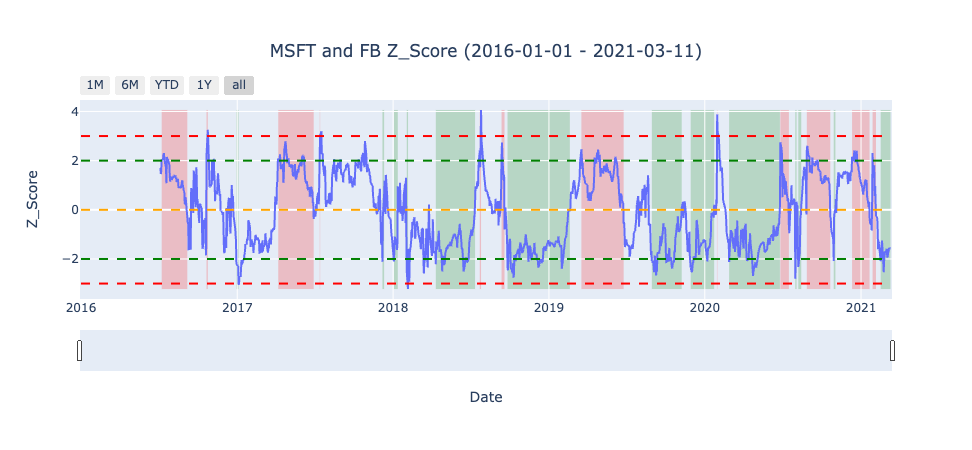

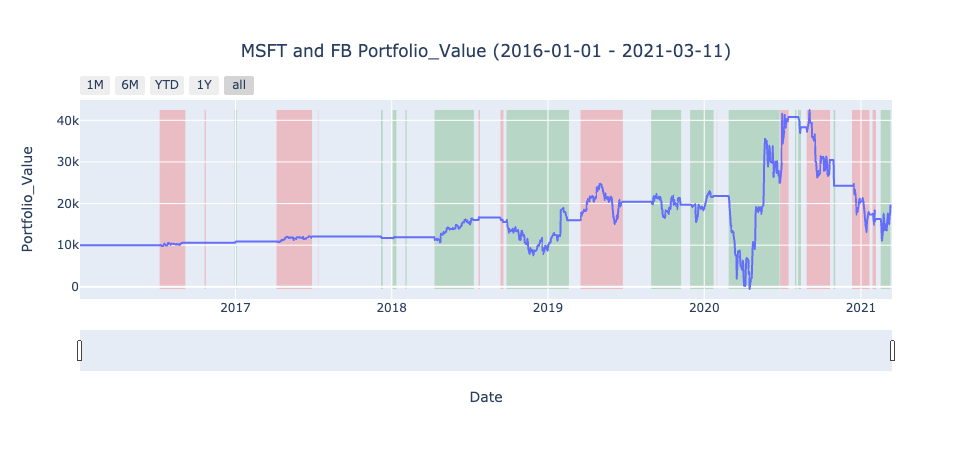

In [409]:
model.backtest_pair()